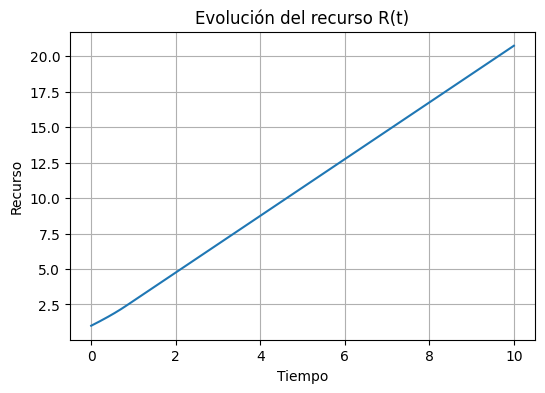

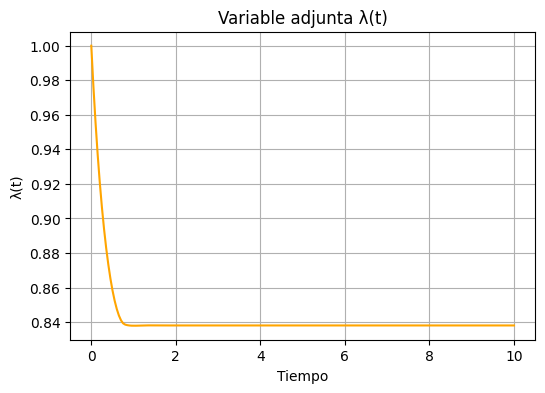

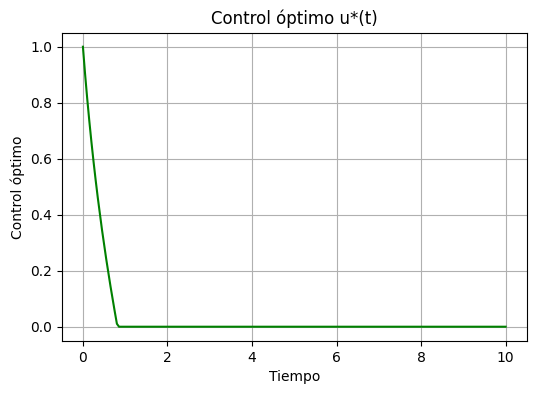

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


r0 = 2
k = 0.5
alpha = 1
T = 10
R0 = 1


def dynamics(t, y):
    R, lam = y

    u = max(0, 1/(lam * k * (R**alpha + 1e-6)) - 1)

    dRdt = r0 - k * (R**alpha) * u
    dlamdt = lam * k * alpha * (R**(alpha-1)) * u
    return [dRdt, -dlamdt]


sol = solve_ivp(dynamics, [0, T], [R0, 1.0], t_eval=np.linspace(0, T, 200))

t = sol.t
R = sol.y[0]
lam = sol.y[1]

u_opt = np.maximum(0, 1/(lam * k * (R**alpha + 1e-6)) - 1)


plt.figure(figsize=(6,4))
plt.plot(t, R, label="R(t)")
plt.xlabel("Tiempo")
plt.ylabel("Recurso")
plt.title("Evolución del recurso R(t)")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(t, lam, label="λ(t)", color="orange")
plt.xlabel("Tiempo")
plt.ylabel("λ(t)")
plt.title("Variable adjunta λ(t)")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(t, u_opt, label="u*(t)", color="green")
plt.xlabel("Tiempo")
plt.ylabel("Control óptimo")
plt.title("Control óptimo u*(t)")
plt.grid()
plt.show()

/tmp/ipython-input-1602973351.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J = np.trapz(a0*I + 0.5*a1*u**2, t)


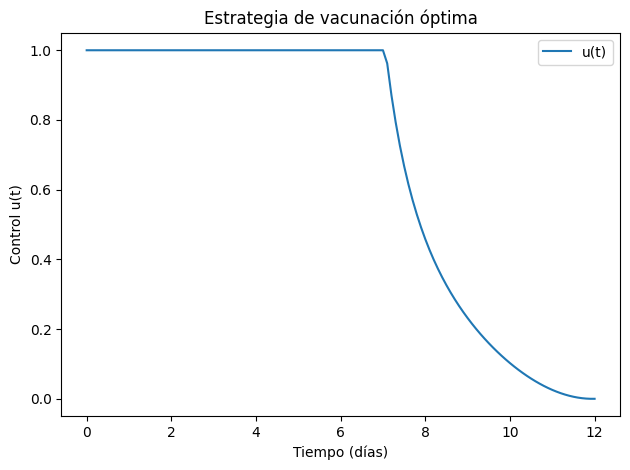

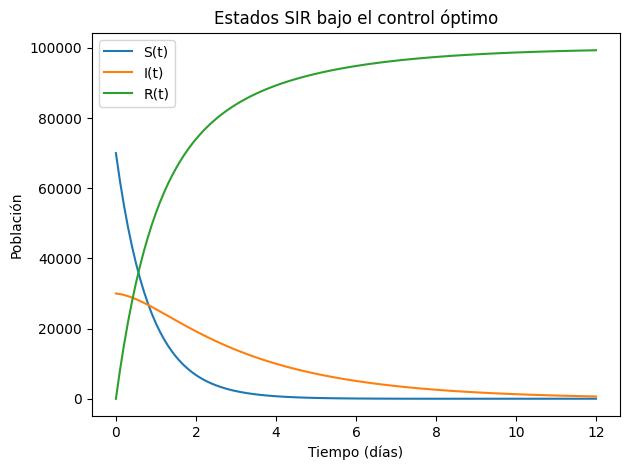

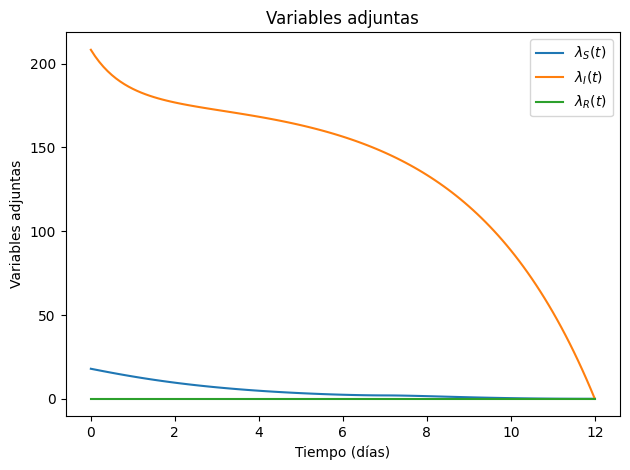

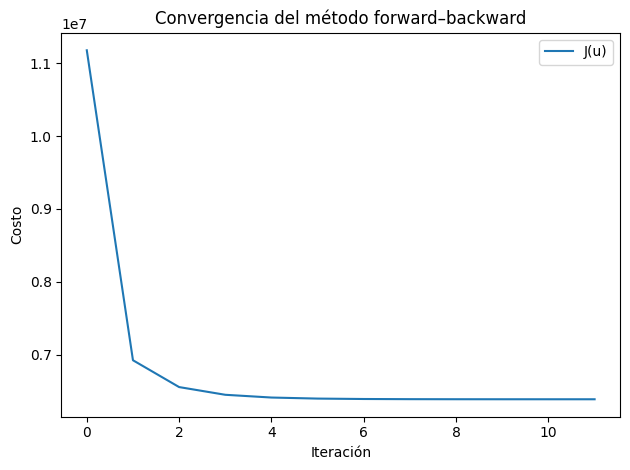

'/content/sir_opt_control_results.csv'

In [ ]:

import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from math import ceil
import pandas as pd

#Parametros

# Parámetros del modelo
N = 100000            # Población total inicial
I0 = 30000            # Infectados iniciales (0.1% de la población)
S0 = N - I0           # Susceptibles iniciales
R0 = 0                # Recuperados iniciales

T = 12                # Horizonte de tiempo en días

beta = 0.4            # Tasa de infección por día
gamma = 1/3           # Tasa de recuperación por día (~3 días)
mu = 1/(75*365)       # Mortalidad natural por día (~75 años)

Lambda = mu * N      # Tasa de muerte (Mantiene la población constante)
a0 = 60              # Peso de la infección
a1 = 60              # Peso para el control



#La cantidad de tiempo modelada
dt = 0.1
n = int(T/dt) + 1
t = np.linspace(0, T, n)

# Usando el PMP el control puede tomar cualquier valor real, pero como en nuestro caso el control representa la proporción de personas vacunadas, esta debe estar entre 0 y 1, por lo tanto se crea
#una función que hace que si da por encima de 1, en vez de tomar ese valor tomo el valor de 1, o si da negativo, tome el valor de cero.
def proj01(x):
    return np.minimum(1.0, np.maximum(0.0, x))

# Aplicación del método de euler hacia adelante para encontrar las ecuaciones de estado.
def forward(u):
    S = np.zeros(n); I = np.zeros(n); R = np.zeros(n)
    S[0], I[0], R[0] = S0, I0, R0


    for k in range(n-1):
        Sk, Ik, Rk = S[k], I[k], R[k]
        uk = u[k]
        dS = Lambda - beta*Sk*Ik/N - mu*Sk - uk*Sk
        dI = beta*Sk*Ik/N - (gamma+mu)*Ik
        dR = gamma*Ik - mu*Rk + uk*Sk
        S[k+1] = Sk + dt*dS
        I[k+1] = Ik + dt*dI
        R[k+1] = Rk + dt*dR

        # Para evitar negativos
        S[k+1] = max(S[k+1], 0.0)
        I[k+1] = max(I[k+1], 0.0)
        R[k+1] = max(R[k+1], 0.0)
    return S, I, R

def backward(S, I, R, u):
    lamS = np.zeros(n); lamI = np.zeros(n); lamR = np.zeros(n)
    # Condiciones terminales
    lamS[-1] = 0.0; lamI[-1] = 0.0; lamR[-1] = 0.0

    #Un ciclo for que desde el ultimo hasta el primer día
    for k in range(n-2, -1, -1):
        Sk, Ik, Rk = S[k+1], I[k+1], R[k+1]
        uk = u[k+1]
        # Ecuaciones Adjuntas que fueron derivadas con el PMP
        dlamS = (beta*Ik/N + mu + uk)*lamS[k+1] - (beta*Ik/N)*lamI[k+1] - uk*lamR[k+1]
        dlamI = -a0 + (beta*Sk/N)*lamS[k+1] - (beta*Sk/N - (gamma+mu))*lamI[k+1] - gamma*lamR[k+1]
        dlamR = mu*lamR[k+1]

        #Integración hacia atrás con el método de euler
        lamS[k] = lamS[k+1] - dt*dlamS
        lamI[k] = lamI[k+1] - dt*dlamI
        lamR[k] = lamR[k+1] - dt*dlamR
    return lamS, lamI, lamR

# Condicion de optimalidad derivada con el PMP
def update_control(S, lamS, lamR):
    raw = -(S/a1)*(lamR - lamS)
    return proj01(raw)

# Estabilidad - Mezcla
max_iter = 200
relax = 0.6 #La importancia que le damos al valor nuevo
tol = 1e-5

u = np.zeros(n)  # Iniciamos sin un control
J_history = [] # Guardamos el valor del funcional

for it in range(max_iter):
    S, I, R = forward(u)
    lamS, lamI, lamR = backward(S, I, R, u)
    u_new = update_control(S, lamS, lamR)
    # aplicar la mezcla a u
    u = relax*u_new + (1-relax)*u

    # calcular el costo computacional
    J = np.trapz(a0*I + 0.5*a1*u**2, t)
    J_history.append(J)
    #Criterio de Parada - El método para cuando la diferencia entre el ultimo y
    #el antepenultimo costo sea menor a la tolerancia.
    if it > 5 and abs(J_history[-2] - J_history[-1])/(1+J_history[-1]) < tol:
        break

# CSV donde se guarda la información
df = pd.DataFrame({
    "t": t,
    "S": S,
    "I": I,
    "R": R,
    "u": u,
    "lambda_S": lamS,
    "lambda_I": lamI,
    "lambda_R": lamR
})


csv_path = "/content/sir_opt_control_results.csv"
df.to_csv(csv_path, index=False)


plt.figure()
plt.plot(t, u, label="u(t)")
plt.xlabel("Tiempo (días)")
plt.ylabel("Control u(t)")
plt.title("Estrategia de vacunación óptima")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, S, label="S(t)")
plt.plot(t, I, label="I(t)")
plt.plot(t, R, label="R(t)")
plt.xlabel("Tiempo (días)")
plt.ylabel("Población")
plt.title("Estados SIR bajo el control óptimo")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, lamS, label=r"$\lambda_S(t)$")
plt.plot(t, lamI, label=r"$\lambda_I(t)$")
plt.plot(t, lamR, label=r"$\lambda_R(t)$")
plt.xlabel("Tiempo (días)")
plt.ylabel("Variables adjuntas")
plt.title("Variables adjuntas")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(np.arange(len(J_history)), J_history, label="J(u)")
plt.xlabel("Iteración")
plt.ylabel("Costo")
plt.title("Convergencia del método forward–backward")
plt.legend()
plt.tight_layout()
plt.show()

csv_path